# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2019

## Integrantes:


#### Ulises Dascalakis   ulises.dasca@live.com.ar
#### Nahuel Seiler          nahuelseiler@gmail.com

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\dot{a} \in A}e^{Q(s,\dot{a})/\tau}}$$



Para dejar el lab listo para su corrección, dejar link a repo de github con un notebook ejecutando el agente en la planilla enviada en Slack.

## Ejemplo 1: The Cliff. 


![](images/cliffwalking.png)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* ^ - Arriba
* v - Abajo
* \> - Derecha
* < - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados 
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Primero, importamos:

In [1]:
import matplotlib.pyplot as plt
import itertools
import gym
import numpy as np
from agents.utils.plotting import plot_reward_per_episode, plot_steps_per_episode, plot_steps_per_episode_smooth, draw_value_matrix

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [2]:
def choose_action(state):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)

    if random_state.uniform() < epsilon:
        return random_state.choice(actions)  # a random action is selected

    count = q_values.count(max_q)

    # In case there're several state-action max values
    # we select a random one among them
    if count > 1:
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        i = q_values.index(max_q)

    return actions[i]

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [3]:
def sarsa_learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """
    
    predict = q.get((state, action),0) 
    target = reward + gamma * q.get((next_state, next_action),0) 
    q[state, action] = predict + alpha * (target - predict)


Finalmente, definimos el método principal de iteraciones. 

In [4]:
def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps
        
        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            next_action = choose_action(next_state)
            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                sarsa_learn(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                sarsa_learn(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [5]:
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

Ya instanciado, ejecutamos nuestro agente

In [6]:
avg_steps_per_episode, timesteps_ep, reward_ep = run()

### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

In [7]:
def plotting_all(reward, timesteps):
    plot_reward_per_episode(reward)
    print("\n")
    plot_steps_per_episode(timesteps)
    plot_steps_per_episode_smooth(timesteps)
    draw_value_matrix(q)

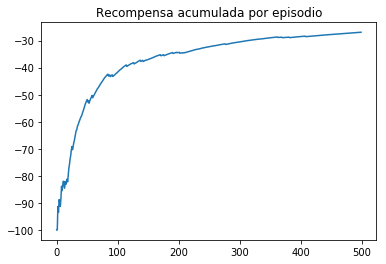

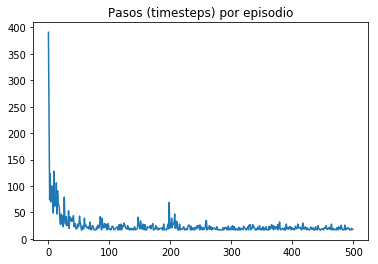

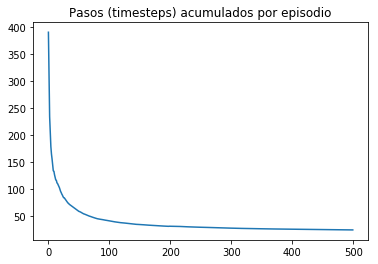

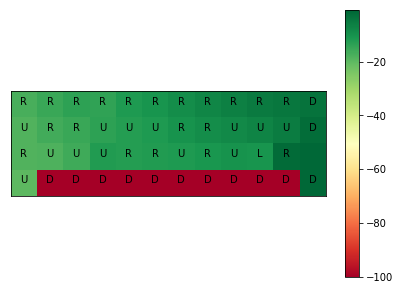


 Matriz de mejor acción-valor (en números): 

 [[ -17.23954428  -15.14316652  -13.47940719  -13.86734791  -11.50591433
   -10.42824021   -8.92910114   -7.36906975   -6.09772006   -5.02260286
    -4.246717     -3.48743802]
 [ -18.17688817  -16.29163152  -15.09887514  -13.57191616  -12.57200446
   -11.46204211  -10.28051994   -8.75636874   -8.02140089   -7.17268501
    -5.41325753   -2.24362335]
 [ -18.16818774  -17.96726471  -16.02741607  -12.12753358  -12.36502775
   -11.94064567  -11.56233996  -10.96253903   -9.96154144  -10.28531687
    -2.00258599   -1.        ]
 [ -19.72790699 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [8]:
plotting_all(reward_ep, timesteps_ep)

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

In [9]:
env.close()

#### Cambiemos algunos hiperparámetros y analicemos los nuevos resultados:

Primero cambiemos sólo el parámetro gamma:

gamma = 0.1

In [10]:
q = {}

alpha = 0.5
gamma = 0.1
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

random_state = np.random.RandomState(42)

In [11]:
avg_steps_per_episode, timesteps_ep, reward_ep = run()

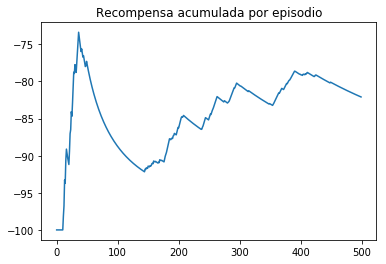

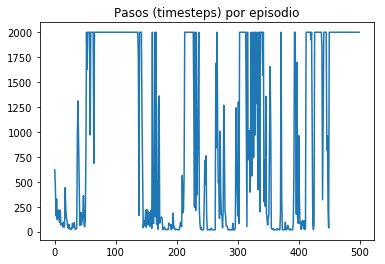

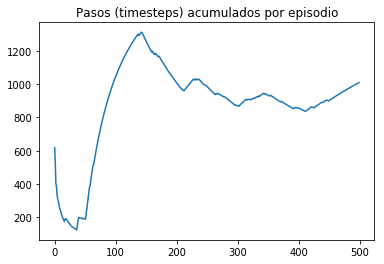

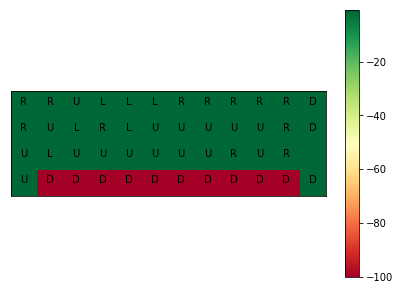


 Matriz de mejor acción-valor (en números): 

 [[  -1.11111111   -1.11111111   -1.11111111   -1.11111113   -1.11111163
    -1.11111826   -1.11111292   -1.11112006   -1.11111028   -1.11110329
    -1.11101645   -1.11001522]
 [  -1.11111111   -1.1111112    -1.11111189   -1.11111637   -1.11111236
    -1.11111204   -1.11111148   -1.11111343   -1.11111109   -1.11111088
    -1.11000602   -1.10002154]
 [  -1.11118832   -1.1111114    -1.11112068   -1.11111114   -1.11111113
    -1.12510165   -1.1111112    -1.11081377   -1.1225684    -1.11111112
    -1.10130718   -1.        ]
 [  -1.11111925 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [12]:
plotting_all(reward_ep, timesteps_ep)

In [13]:
env.close()

gamma = 0.5

In [14]:
q = {}

alpha = 0.5
gamma = 0.5
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

random_state = np.random.RandomState(42)

In [15]:
avg_steps_per_episode, timesteps_ep, reward_ep = run()

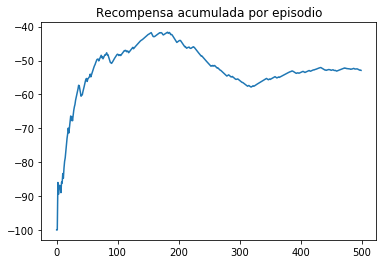

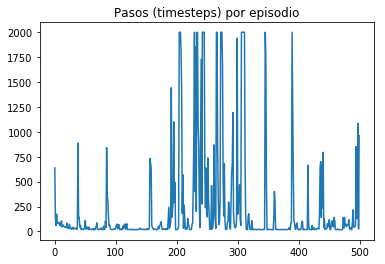

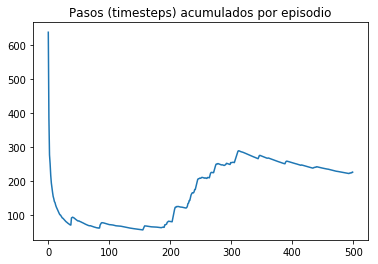

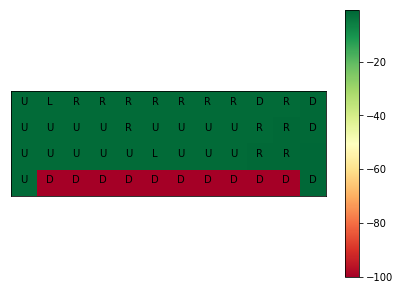


 Matriz de mejor acción-valor (en números): 

 [[  -2.0000404    -2.00006269   -1.999969     -2.00102349   -1.99892658
    -1.99699843   -1.99309237   -1.98511163   -1.9726272    -1.9513255
    -1.88695454   -1.77338232]
 [  -2.00004983   -2.00010558   -2.00032932   -1.99983658   -2.00001534
    -1.9990904    -2.00119601   -1.99716416   -1.99439299   -1.88867755
    -1.75002864   -1.50000245]
 [  -2.00001435   -2.00027401   -2.04109583   -2.00111573   -2.00960118
    -2.03768728   -2.00643212   -2.00960147   -2.00022283   -1.76755296
    -1.50390017   -1.        ]
 [  -2.00722497 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [16]:
plotting_all(reward_ep, timesteps_ep)

In [17]:
env.close()

Vemos que la elección de un gamma=0.5 alcanza mayores valores de recompensa que un gamma=0.1, pero un gamma=1 arroja aún mejores valores, o sea que para esta configuración considerar todas las recompensas de la misma manera termina siendo más efectivo.

Pero este análisis no puede ser considerado como método de elección del modelo más efectivo ya que debemos también analizar la influencia de los parámetros alfa y epsilon, es decir el "learning rate" y la probabilidad de elegir una acción aleatoria

Probemos entonces distintas configuraciones con algunos otros parámetros

Para ello tendremos en cuenta los siguientes valores:

gamma -> {0.1, 0.5, 1}

alfa -> {0.1, 0.5}

epsilon -> {0.05, 0.1, 0.5}



VALORES GAMMA=0.1 ALFA=0.1 EPSILON=0.05


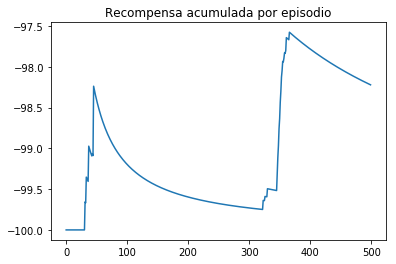

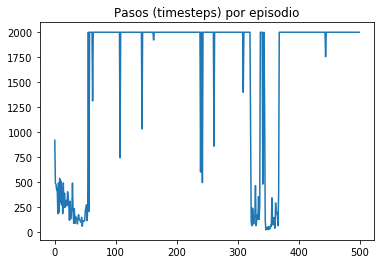

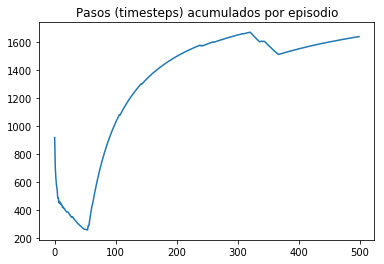

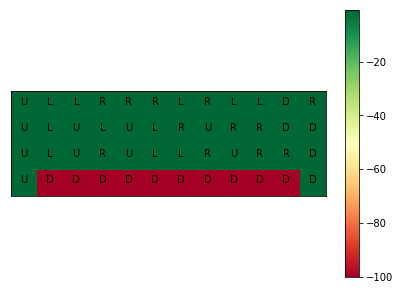


 Matriz de mejor acción-valor (en números): 

 [[  -1.11111111   -1.11111111   -1.11111111   -1.11111113   -1.11111113
    -1.11111103   -1.11111055   -1.11110767   -1.11109152   -1.11100208
    -1.11053588   -1.10884233]
 [  -1.11111111   -1.11111111   -1.11111307   -1.11111225   -1.11110947
    -1.11109165   -1.11110819   -1.11110243   -1.11108117   -1.11091407
    -1.10952601   -1.09985394]
 [  -1.11111172   -1.11111062   -1.11111069   -1.1094943    -1.11071944
    -1.09914224   -1.10560742   -1.10809947   -1.10978031   -1.10805847
    -1.09846476   -0.9999873 ]
 [  -1.11116988 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.1 ALFA=0.1 EPSILON=0.1


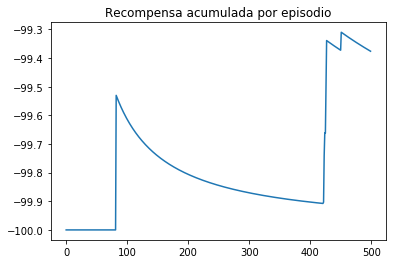

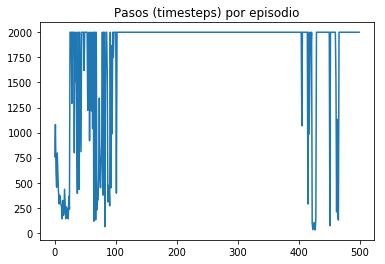

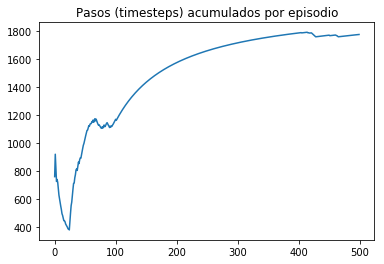

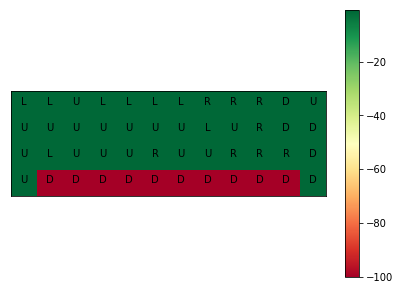


 Matriz de mejor acción-valor (en números): 

 [[  -1.11111112   -1.11111113   -1.11111133   -1.11111161   -1.11111124
    -1.11111113   -1.11111122   -1.11110826   -1.11108529   -1.110927
    -1.11013975   -1.10781927]
 [  -1.11111113   -1.11111431   -1.11111149   -1.11111117   -1.11112026
    -1.11111127   -1.11111112   -1.11112099   -1.11051043   -1.11009287
    -1.107695     -1.09835948]
 [  -1.11111242   -1.11154222   -1.08913484   -1.05327704   -1.10751631
    -1.10352391   -1.1103968    -1.11106205   -1.08292638   -1.10506274
    -1.09752968   -0.99982304]
 [  -1.11113119 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.1 ALFA=0.1 EPSILON=0.5


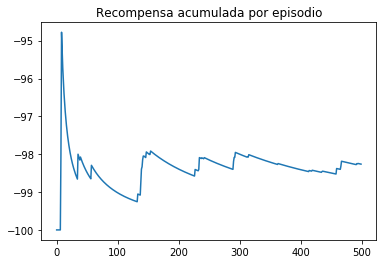

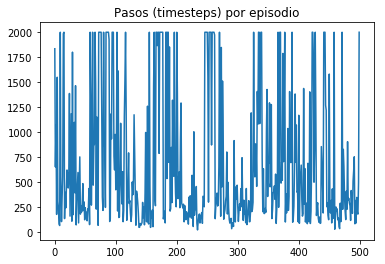

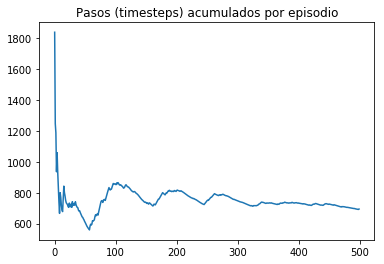

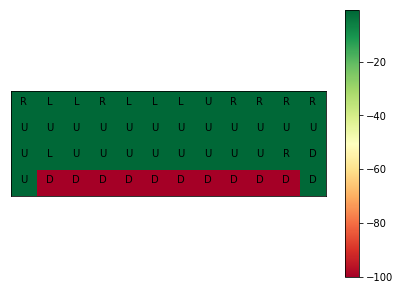


 Matriz de mejor acción-valor (en números): 

 [[  -1.11111742   -1.11113086   -1.11117042   -1.11132841   -1.11129255
    -1.1112853    -1.11131498   -1.1112412    -1.11114969   -1.11115321
    -1.11111308   -1.1111141 ]
 [  -1.11111698   -1.11118695   -1.11124378   -1.11142764   -1.11128976
    -1.11139397   -1.11136239   -1.11177106   -1.11134811   -1.11116379
    -1.11112052   -1.11111337]
 [  -1.11190597   -1.14660373   -1.11153441   -1.11831843   -1.1239094
    -1.11834453   -1.11988478   -1.11496503   -1.13103181   -1.13323378
    -1.11408736   -1.        ]
 [  -1.15824443 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.1 ALFA=0.5 EPSILON=0.05


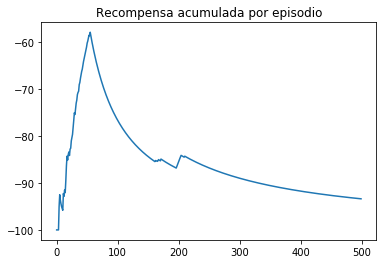

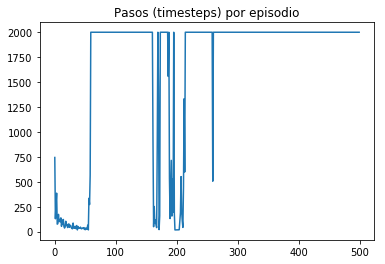

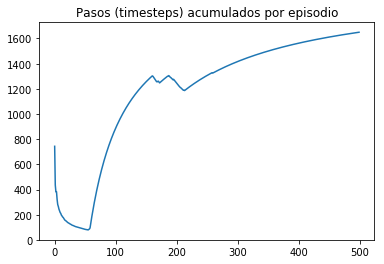

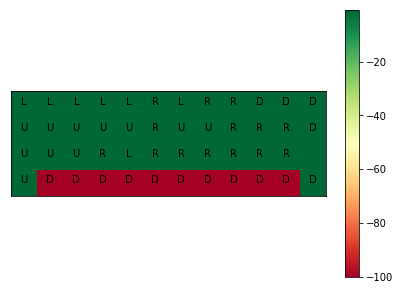


 Matriz de mejor acción-valor (en números): 

 [[  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.11111111
    -1.11111374   -1.1111144    -1.111111     -1.11111002   -1.11110054
    -1.1110057    -1.1101879 ]
 [  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.11111113
    -1.11111111   -1.11111115   -1.1111111    -1.11110028   -1.11100092
    -1.11000098   -1.1       ]
 [  -1.11111111   -1.11111111   -1.11111111   -1.11111105   -1.111111
    -1.11111101   -1.11111014   -1.11110449   -1.11104935   -1.11018787
    -1.10093875   -1.        ]
 [  -1.11111129 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.1 ALFA=0.5 EPSILON=0.1


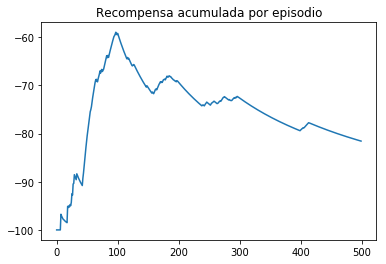

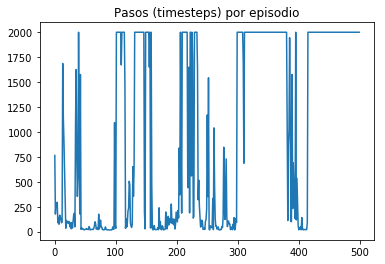

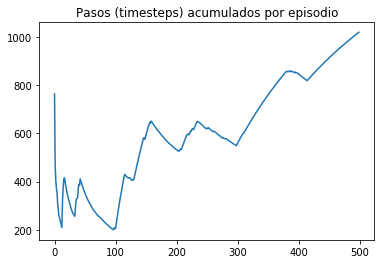

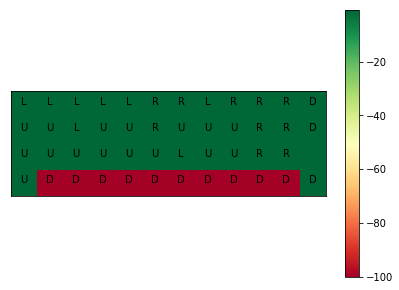


 Matriz de mejor acción-valor (en números): 

 [[  -1.11111111   -1.11111111   -1.11111111   -1.11111112   -1.1111184
    -1.11111344   -1.11111121   -1.11111111   -1.11111018   -1.1111011
    -1.11100862   -1.1100402 ]
 [  -1.11111112   -1.11111111   -1.11111337   -1.11111401   -1.11111113
    -1.11111182   -1.11111111   -1.11111117   -1.11111084   -1.11103467
    -1.11014419   -1.10007869]
 [  -1.11111111   -1.1111422    -1.11111784   -1.1111164    -1.11111111
    -1.1111135    -1.10824482   -1.11111112   -1.11110998   -1.11
    -1.1          -1.        ]
 [  -1.11111112 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.1 ALFA=0.5 EPSILON=0.5


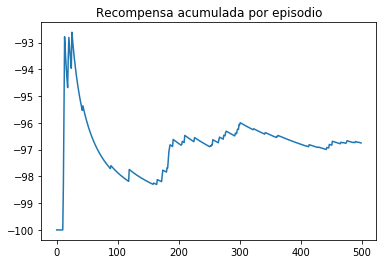

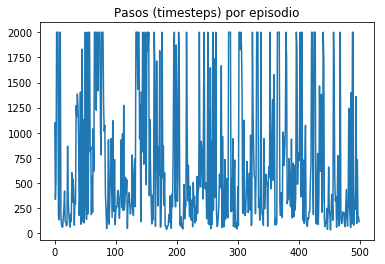

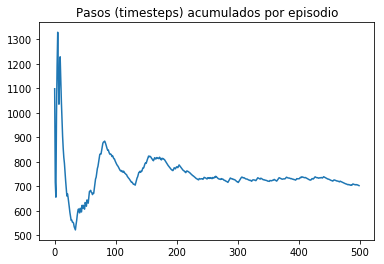

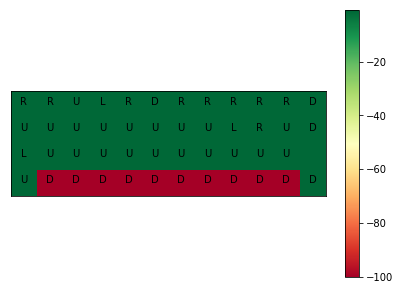


 Matriz de mejor acción-valor (en números): 

 [[  -1.11111446   -1.11111209   -1.11111197   -1.11111911   -1.1111183
    -1.11113576   -1.11111335   -1.111122     -1.11111165   -1.1111116
    -1.11106664   -1.11060222]
 [  -1.11111175   -1.11114135   -1.11111168   -1.11133783   -1.11114212
    -1.1111518    -1.11139469   -1.11117096   -1.11114664   -1.11111346
    -1.11111682   -1.1041449 ]
 [  -1.11130454   -1.11177445   -1.11305921   -1.1111441    -1.12651858
    -1.11138898   -1.1237584    -1.11124066   -1.1111345    -1.11156642
    -1.11111338   -1.        ]
 [  -1.11120325 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.5 ALFA=0.1 EPSILON=0.05


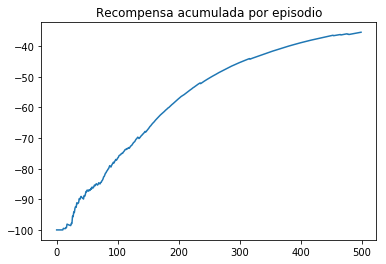

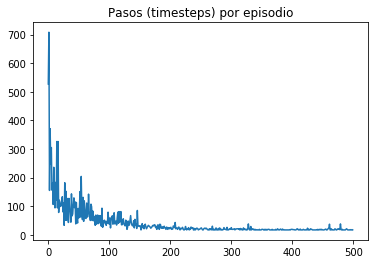

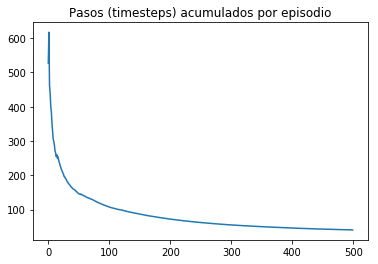

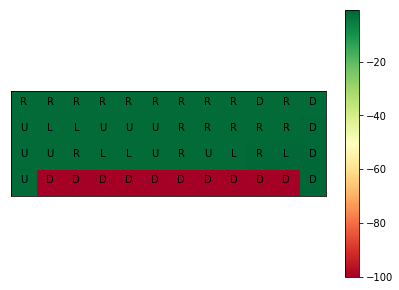


 Matriz de mejor acción-valor (en números): 

 [[  -1.99989661   -1.99979169   -1.99956237   -1.99909443   -1.99815943
    -1.99630432   -1.99256418   -1.98515229   -1.97077412   -1.94256773
    -1.88821417   -1.78847191]
 [  -1.99994745   -1.99987581   -1.99805905   -1.9991095    -1.99798922
    -1.99733809   -1.98629906   -1.97305684   -1.94668393   -1.88577229
    -1.77385821   -1.54472999]
 [  -1.99997359   -1.99920002   -1.98653004   -1.98293548   -1.97837173
    -1.99257017   -1.94177627   -1.96702698   -1.95289869   -1.60163463
    -1.42699683   -1.        ]
 [  -2.00151912 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.5 ALFA=0.1 EPSILON=0.1


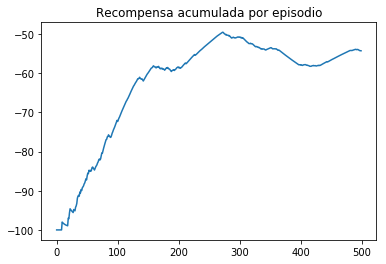

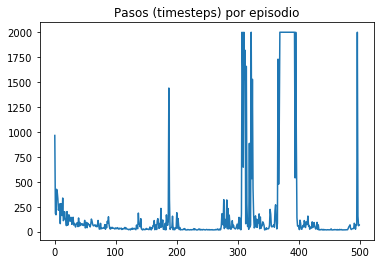

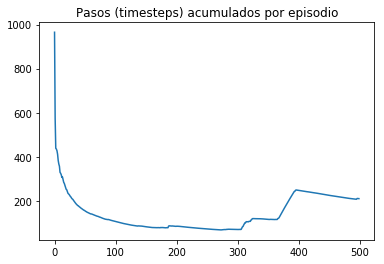

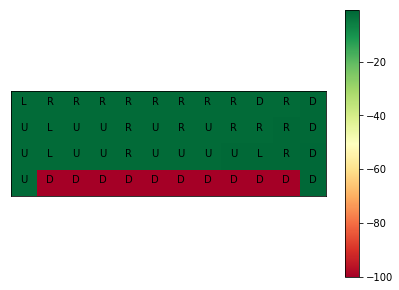


 Matriz de mejor acción-valor (en números): 

 [[  -2.00001386   -2.00006506   -1.99963777   -1.99918172   -1.99840316
    -1.99696834   -1.99498331   -1.98739856   -1.97278296   -1.94411697
    -1.88759752   -1.76234778]
 [  -2.00007134   -2.00083509   -2.00005278   -1.99994592   -1.99704614
    -1.99829936   -1.9754938    -1.96889081   -1.94747924   -1.88690475
    -1.76692632   -1.51065969]
 [  -2.00219896   -1.99828289   -1.99232761   -1.94273334   -1.80415246
    -1.84029673   -1.80593591   -1.96291815   -1.4959757    -1.50588706
    -1.515387     -1.        ]
 [  -2.11384647 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.5 ALFA=0.1 EPSILON=0.5


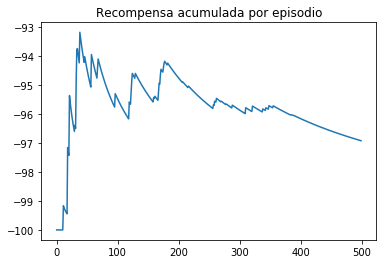

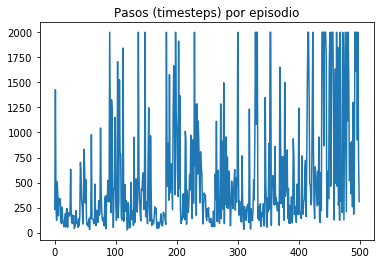

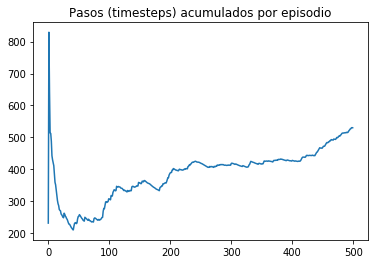

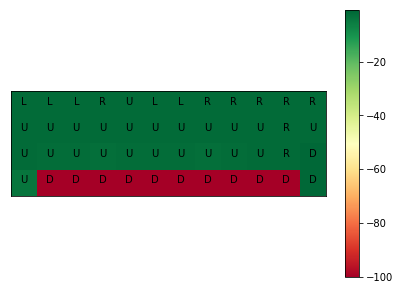


 Matriz de mejor acción-valor (en números): 

 [[  -2.02441526   -2.03272153   -2.03857083   -2.06288668   -2.06939045
    -2.05885858   -2.06774303   -2.06055142   -2.03360599   -2.02391664
    -2.00575485   -2.0062909 ]
 [  -2.01812594   -2.05558931   -2.03031491   -2.07658373   -2.0507463
    -2.05625953   -2.0748224    -2.03624868   -2.07493042   -2.02712703
    -2.03981931   -2.00492711]
 [  -2.15546268   -2.20786105   -2.34543344   -2.81172879   -2.51190959
    -2.3200129    -2.32085766   -2.62841828   -2.19692863   -2.14370689
    -1.9895961    -1.        ]
 [  -3.86630103 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.5 ALFA=0.5 EPSILON=0.05


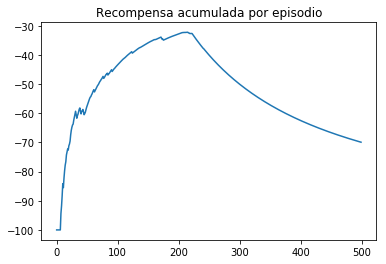

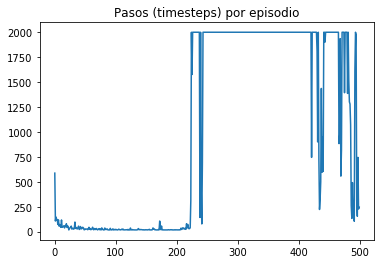

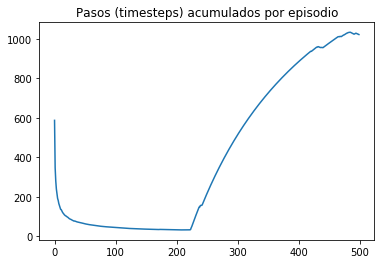

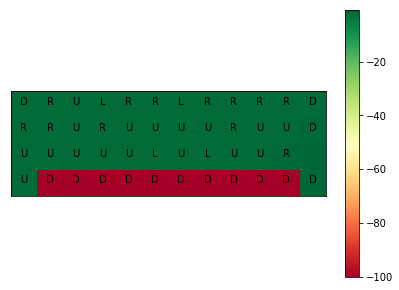


 Matriz de mejor acción-valor (en números): 

 [[  -2.00162983   -2.00041067   -2.00156839   -2.           -2.01199636
    -2.00842968   -2.00016758   -1.99239313   -1.98846192   -1.97834488
    -1.9462291    -1.80554664]
 [  -2.00018782   -2.00020853   -2.00088105   -2.00039764   -2.00017418
    -2.01462456   -2.00113772   -2.00230045   -2.           -2.00207472
    -1.97195847   -1.50174084]
 [  -2.00017679   -2.00036697   -2.00058402   -2.00014745   -2.0008547
    -2.00031831   -1.99873575   -1.99480512   -1.99976114   -1.99121995
    -1.52530484   -1.        ]
 [  -2.00015506 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.5 ALFA=0.5 EPSILON=0.1


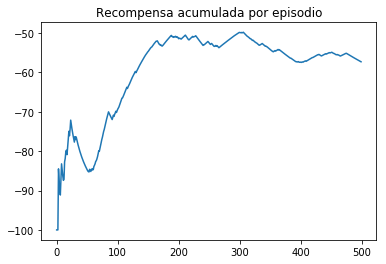

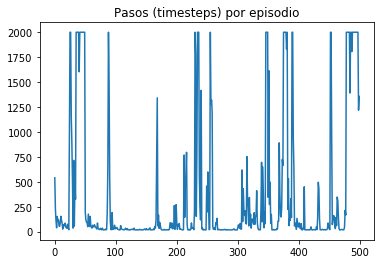

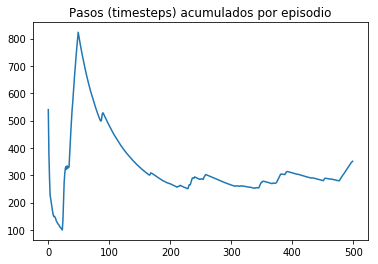

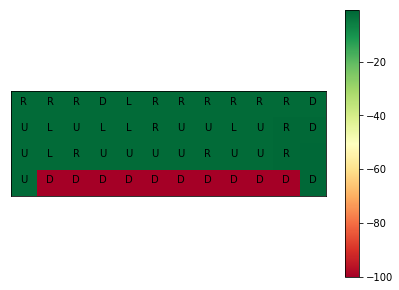


 Matriz de mejor acción-valor (en números): 

 [[  -2.00200216   -2.00297416   -2.0009404    -2.00025887   -2.00014658
    -2.00120903   -1.99842498   -1.99018553   -1.97627176   -1.94759448
    -1.90125951   -1.83841658]
 [  -2.00710334   -2.0012365    -2.00646904   -2.01301887   -2.00400921
    -2.00468775   -2.02820939   -2.00298388   -2.1182657    -1.98776662
    -1.75146083   -1.61925443]
 [  -2.00785594   -2.00929357   -2.06178339   -2.00359445   -2.00677293
    -2.00226262   -2.00065724   -2.0048815    -2.05397096   -1.99666654
    -1.50000265   -1.        ]
 [  -2.00280727 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.5 ALFA=0.5 EPSILON=0.5


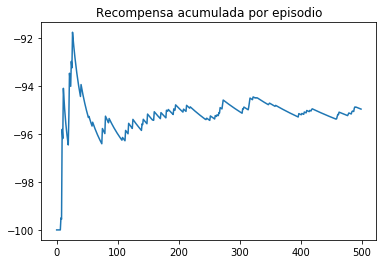

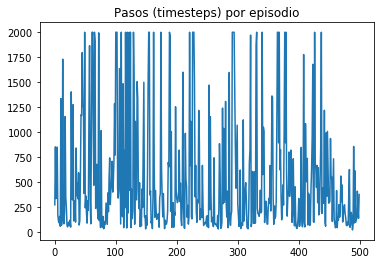

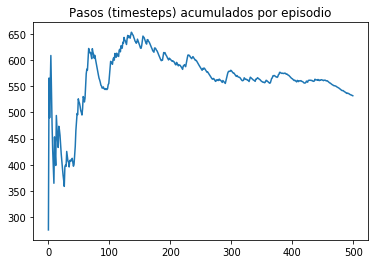

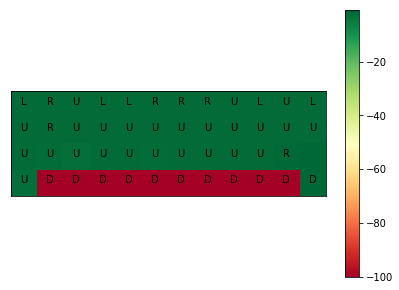


 Matriz de mejor acción-valor (en números): 

 [[  -2.02758384   -2.01408587   -2.011852     -2.00764528   -2.00961618
    -2.01166349   -2.01099837   -2.00257765   -2.00467666   -2.00280688
    -2.00226738   -2.00069916]
 [  -2.05566139   -2.01446514   -2.00489172   -2.01689587   -2.04158441
    -2.05232439   -2.00793687   -2.04256588   -2.01123936   -2.01115332
    -2.01703259   -2.00138155]
 [  -2.12963403   -2.16157461   -2.87171636   -2.15434766   -2.04732393
    -2.24829306   -2.02575719   -2.07879844   -2.08755032   -2.01970206
    -1.72175257   -1.        ]
 [  -2.67548204 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=1 ALFA=0.1 EPSILON=0.05


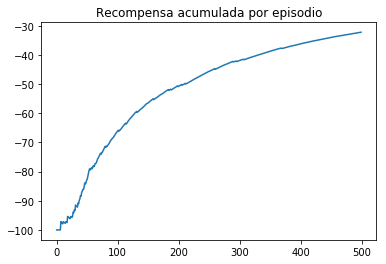

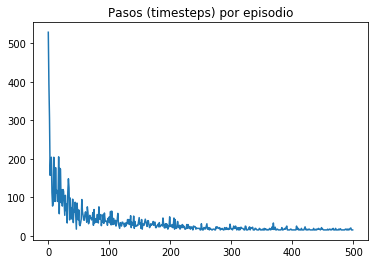

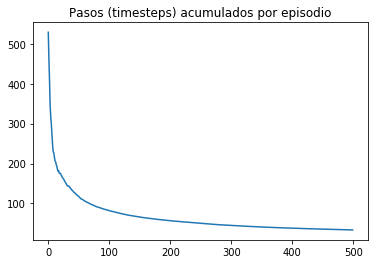

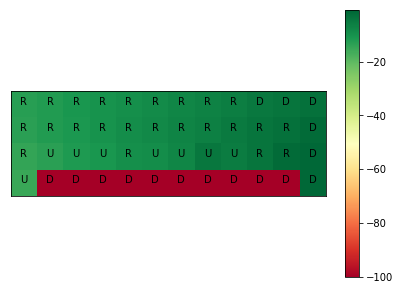


 Matriz de mejor acción-valor (en números): 

 [[ -12.60313408  -11.8774885   -11.0469097   -10.1737233    -9.29265239
    -8.40989246   -7.54216923   -6.63277381   -5.72583057   -4.80491646
    -3.91524244   -2.99828472]
 [ -13.24361238  -12.14548759  -11.14049268  -10.13166347   -9.11506223
    -8.09809663   -7.09424709   -6.08978588   -5.10297322   -4.07435976
    -3.03504287   -2.04462661]
 [ -14.14910445  -13.08369211  -11.5363562   -10.93609036   -9.33962881
    -8.80012163   -7.24667196   -4.46901004   -5.32834323   -3.75396098
    -2.02775259   -1.        ]
 [ -15.1458844  -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=1 ALFA=0.1 EPSILON=0.1


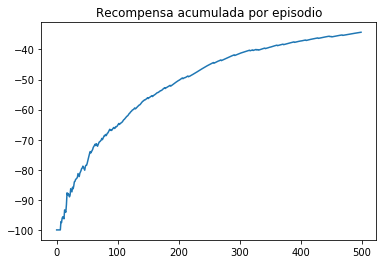

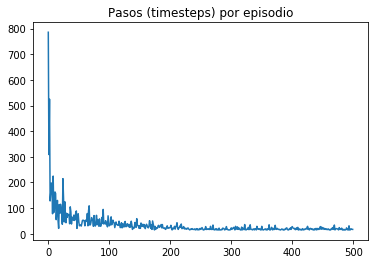

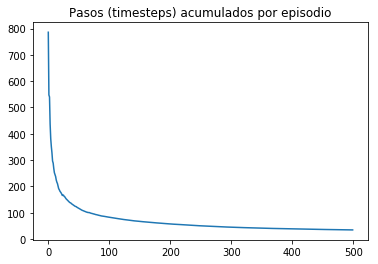

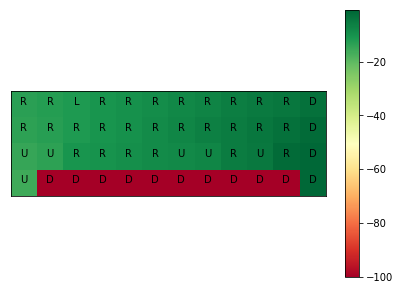


 Matriz de mejor acción-valor (en números): 

 [[ -13.16508859  -12.34231749  -11.50057261  -10.63158862   -9.73446321
    -8.83214979   -7.94176532   -6.99966871   -6.02617139   -5.06759933
    -4.11665249   -3.18701167]
 [ -13.70375085  -12.70728615  -11.64968724  -10.6620221    -9.56451835
    -8.58045438   -7.455288     -6.30192092   -5.27878979   -4.26335886
    -3.20074567   -2.08149373]
 [ -14.72022263  -13.54851155  -10.54479135  -10.00910877   -9.33350324
    -8.65077411   -8.09187505   -7.37028342   -5.26593348   -4.69472059
    -2.06345672   -1.        ]
 [ -15.80016694 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=1 ALFA=0.1 EPSILON=0.5


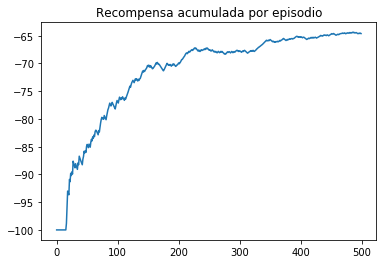

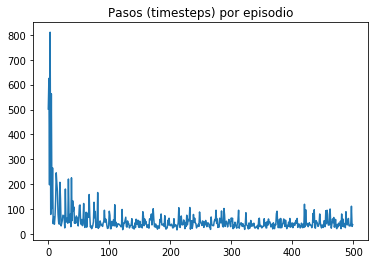

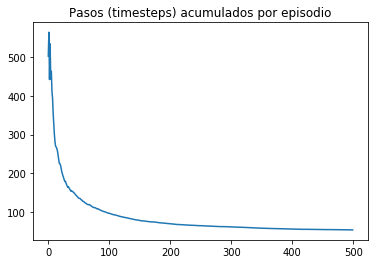

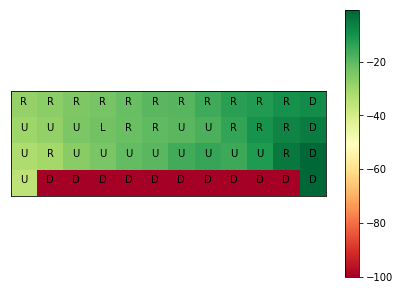


 Matriz de mejor acción-valor (en números): 

 [[ -28.2549166   -26.66559463  -24.87115482  -23.62610369  -21.46917599
   -19.45744575  -18.99971502  -15.90061365  -13.33221694  -12.02160023
    -9.79877863   -8.35903252]
 [ -29.70796376  -27.7532988   -24.53111502  -23.00556992  -21.87199697
   -19.98202556  -19.3884689   -17.34762482  -14.41811195  -10.11102278
    -6.88036444   -5.59598376]
 [ -32.60316601  -30.54668041  -26.37494291  -23.83848785  -20.35189157
   -19.35996451  -16.3622958   -14.84853984  -15.58707304  -11.80648798
    -4.69340228   -1.        ]
 [ -35.12617352 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=1 ALFA=0.5 EPSILON=0.05


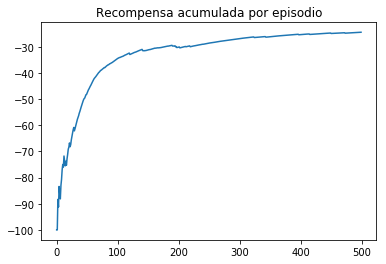

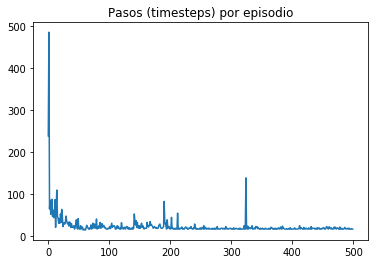

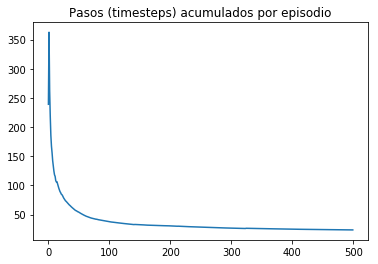

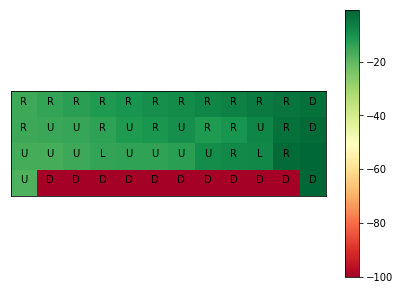


 Matriz de mejor acción-valor (en números): 

 [[ -15.43558833  -14.50031184  -13.24481816  -11.7290552   -10.4757202
    -9.37898205   -8.37333968   -7.31549184   -6.19248451   -5.07840895
    -4.01900832   -3.00207151]
 [ -15.56350031  -14.98409205  -14.60125378  -13.50136005  -11.729643
   -10.79084657   -9.32267381  -11.81090062  -10.55866011   -7.27782058
    -3.01608556   -2.00000001]
 [ -16.63857164  -16.85328038  -15.45842211  -14.41877269  -14.04390559
   -14.09268207  -13.2908195    -8.95290154   -7.9897595    -7.92154785
    -1.99999499   -1.        ]
 [ -17.86521132 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=1 ALFA=0.5 EPSILON=0.1


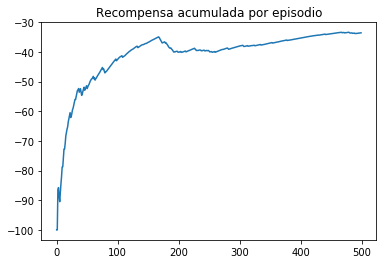

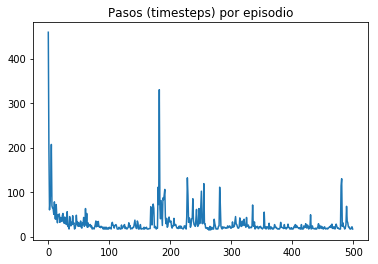

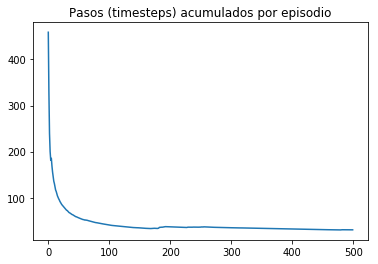

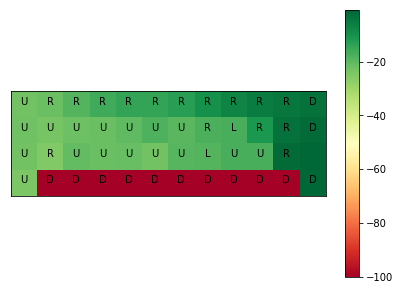


 Matriz de mejor acción-valor (en números): 

 [[ -22.88204856  -21.54846054  -18.50296368  -15.82313938  -14.3891296
   -14.1942942   -12.66633672   -9.55446993   -7.06270671   -5.49249283
    -4.18077158   -3.03322443]
 [ -22.47662962  -23.53306351  -22.23454375  -21.55750974  -20.12824692
   -17.86597454  -19.36320657  -17.33773842  -17.11679388  -11.43792946
    -3.0051675    -2.        ]
 [ -22.93064739  -25.01210679  -20.41188218  -21.84515317  -21.18109385
   -22.90800096  -18.81760847  -18.72365773  -16.86415662  -16.9501017
    -2.00197611   -1.        ]
 [ -24.4593399  -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=1 ALFA=0.5 EPSILON=0.5


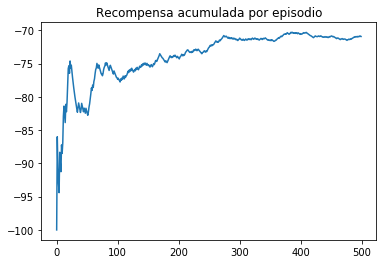

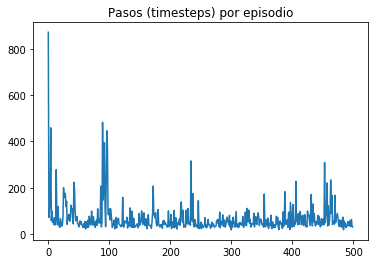

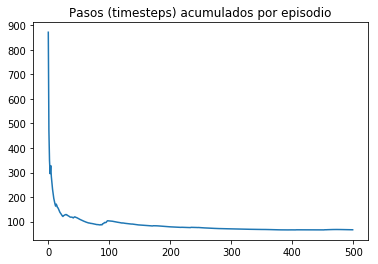

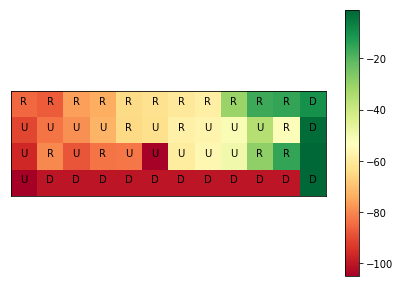


 Matriz de mejor acción-valor (en números): 

 [[ -85.18178195  -87.10364873  -75.99105603  -73.77623694  -64.38858213
   -62.71365323  -60.22179815  -58.17201105  -30.36524062  -16.27740471
   -14.94106672  -10.24472748]
 [ -90.59998617  -83.00126125  -78.67725001  -72.59817957  -64.73127851
   -62.89172275  -57.95724046  -56.48878343  -51.45762121  -35.47527431
   -52.12590081   -2.23171875]
 [ -96.38005818  -79.96256685  -88.28258735  -82.84906142  -82.7483668
  -104.55575646  -59.33478764  -55.75399687  -49.34948129  -28.93770348
   -14.92420575   -1.        ]
 [-105.22571791 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [18]:
lista_gamma = [0.1, 0.5, 1]
lista_alfa = [0.1, 0.5]
lista_epsilon = [0.05, 0.1, 0.5]

for i in lista_gamma:
    for j in lista_alfa:
        for k in lista_epsilon:
            q = {}

            alpha = j
            gamma = i
            epsilon = k
            tau = 25

            episodes_to_run = 500

            env = gym.make("CliffWalking-v0")
            actions = range(env.action_space.n)
            
            print("\n")
            print("VALORES GAMMA={} ALFA={} EPSILON={}".format(gamma, alpha, epsilon))

            avg_steps_per_episode, timesteps_ep, reward_ep = run()
            plotting_all(reward_ep, timesteps_ep)
            env.close()


Según los gráficos anteriores, concluimos que la mejor configuración obtenida fue:

##### GAMMA=1 ALFA=0.5 EPSILON=0.05

es decir que SARSA para este problema pareciera que se comporta mejor con learning rates más altos y valores de elección aleatoria más bajos.



## Q-Learning

In [19]:
def choose_action_ql(state, q, actions, epsilon):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)

    if random_state.uniform() < epsilon:
        return random_state.choice(actions)  # a random action is selected

    count = q_values.count(max_q)

    # In case there're several state-action max values
    # we select a random one among them
    if count > 1:
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        i = q_values.index(max_q)

    return actions[i]

In [20]:
def qlearning(state, action, reward, next_state, q, gamma, alpha):
    """
    Performs a q-learning update for a given state transition
    """

    predict = q.get((state, action),0.0)
    q_values = [q.get((next_state, a), 0.0) for a in actions]
    target = reward + gamma * (max(q_values))
    
    q[(state,action)] = predict + alpha*(target-predict)
    
    

In [21]:
def run_qlearning(q, gamma, alpha, epsilon, actions):
    """
    Modificacion del metodo run de sarsa, para usar el algoritmo de Qlearning.
    """
    # numero de pasos por espisodio
    timesteps_of_episode = []
    
    #lista de recompensas dadas al agente en cada episodio
    reward_of_episode = []

    for i_episode in range(episodes_to_run):        
        state = env.reset()
        
        episode_reward = 0
        done = False
        t = 0
                
        while not done:
            action = choose_action_ql(state, q, actions, epsilon)
            next_state, reward, done, info = env.step(action)
            episode_reward += reward

            if not done and t < 2000: #si no converge se frena luego de 2000 iteraciones
                qlearning(state, action, reward, next_state, q, gamma, alpha)
                state = next_state

            else:
                done = True  #si no converge
                qlearning(state, action, reward, next_state, q, gamma, alpha)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

### Realicemos el mismo análisis que hicimos con SARSA con diferentes hiperparámetros y veamos los resultados:



VALORES GAMMA=0.1 ALFA=0.1 EPSILON=0.05


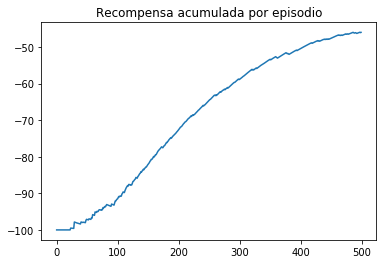

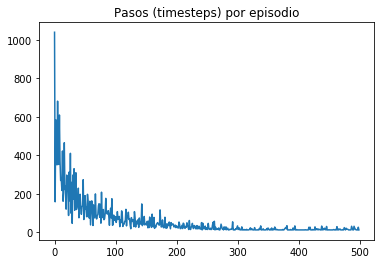

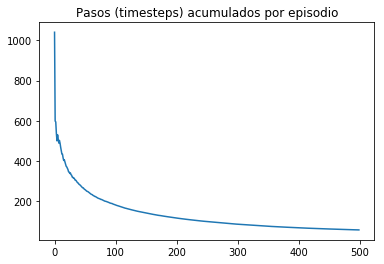

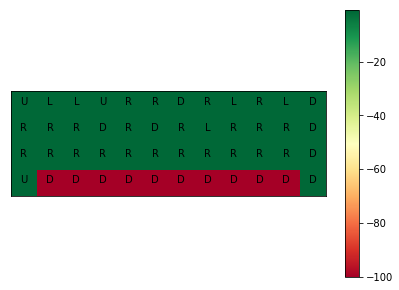


 Matriz de mejor acción-valor (en números): 

 [[  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.1111111
    -1.11111107   -1.11111081   -1.1111092    -1.11109869   -1.11103425
    -1.11067419   -1.10923508]
 [  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.1111111
    -1.11111106   -1.1111107    -1.11110812   -1.11108744   -1.11093179
    -1.10980582   -1.09995979]
 [  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.1111111
    -1.111111     -1.11111      -1.1111       -1.111        -1.11
    -1.1          -1.        ]
 [  -1.11111111 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.1 ALFA=0.1 EPSILON=0.1


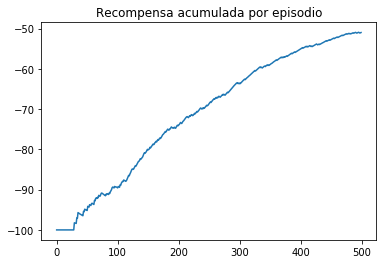

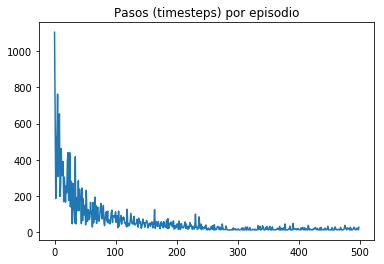

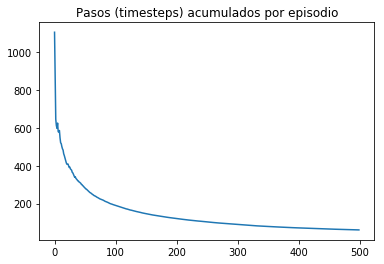

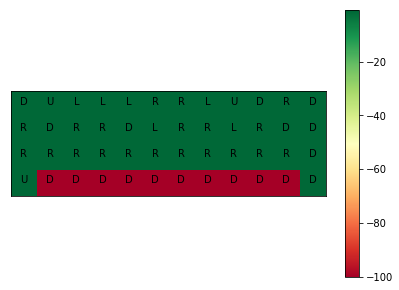


 Matriz de mejor acción-valor (en números): 

 [[  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.1111111
    -1.11111107   -1.11111086   -1.11110953   -1.11110088   -1.11104885
    -1.11073123   -1.10937828]
 [  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.11111111
    -1.11111107   -1.11111078   -1.11110857   -1.11109154   -1.11096096
    -1.10985145   -1.09998558]
 [  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.1111111
    -1.111111     -1.11111      -1.1111       -1.111        -1.11
    -1.1          -1.        ]
 [  -1.11111111 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.1 ALFA=0.1 EPSILON=0.5


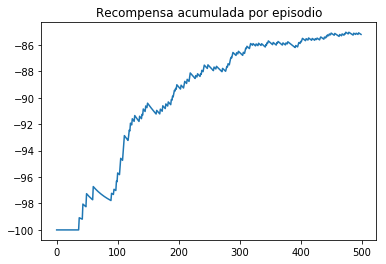

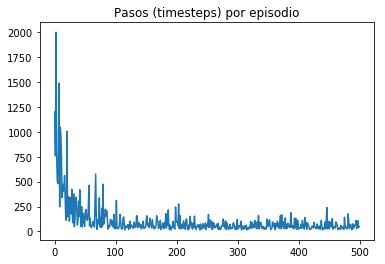

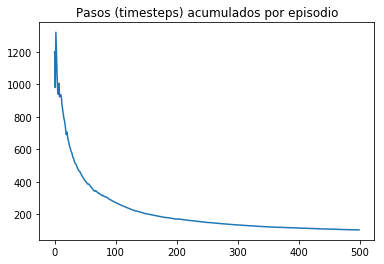

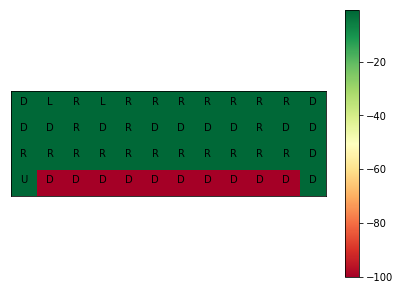


 Matriz de mejor acción-valor (en números): 

 [[  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.11111111
    -1.11111111   -1.1111111    -1.11111099   -1.11110996   -1.11109981
    -1.11099944   -1.10999998]
 [  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.11111111
    -1.1111111    -1.111111     -1.11111      -1.1111       -1.111
    -1.11         -1.1       ]
 [  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.1111111
    -1.111111     -1.11111      -1.1111       -1.111        -1.11
    -1.1          -1.        ]
 [  -1.11111111 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.1 ALFA=0.5 EPSILON=0.05


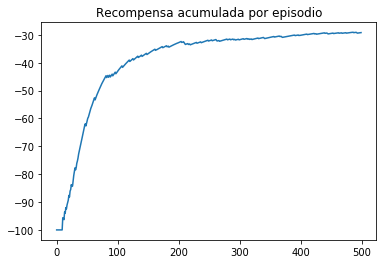

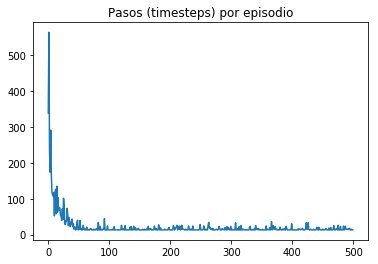

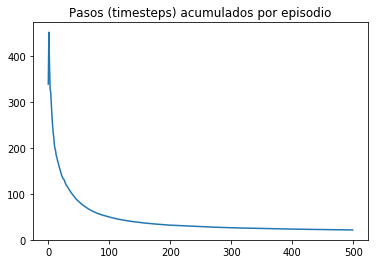

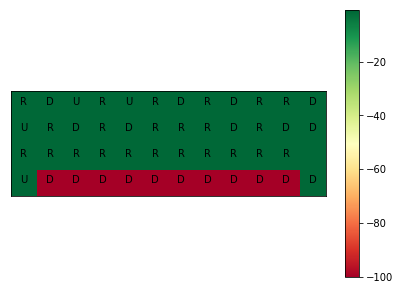


 Matriz de mejor acción-valor (en números): 

 [[  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.11111111
    -1.1111111    -1.11111103   -1.11111053   -1.11110738   -1.1110855
    -1.11091167   -1.10987288]
 [  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.11111111
    -1.1111111    -1.111111     -1.11110999   -1.11109995   -1.11099988
    -1.10999978   -1.1       ]
 [  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.1111111
    -1.111111     -1.11111      -1.1111       -1.111        -1.11
    -1.1          -1.        ]
 [  -1.11111111 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.1 ALFA=0.5 EPSILON=0.1


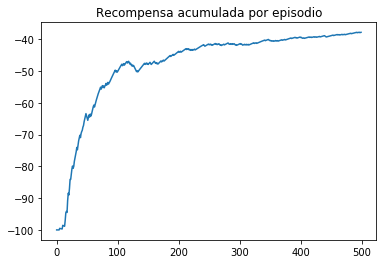

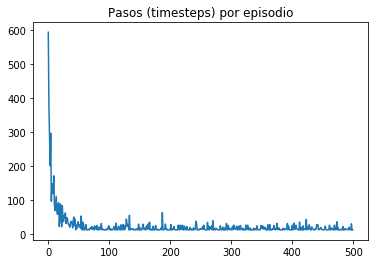

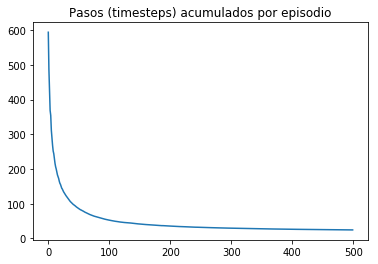

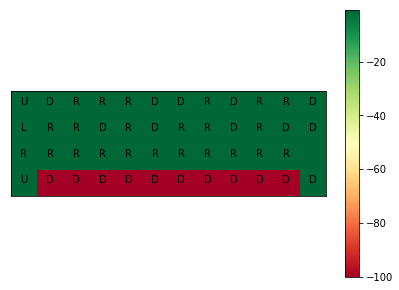


 Matriz de mejor acción-valor (en números): 

 [[  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.11111111
    -1.11111111   -1.11111108   -1.11111086   -1.11110924   -1.1110956
    -1.11098388   -1.10998098]
 [  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.11111111
    -1.1111111    -1.111111     -1.11111      -1.1111       -1.111
    -1.11         -1.1       ]
 [  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.1111111
    -1.111111     -1.11111      -1.1111       -1.111        -1.11
    -1.1          -1.        ]
 [  -1.11111111 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.1 ALFA=0.5 EPSILON=0.5


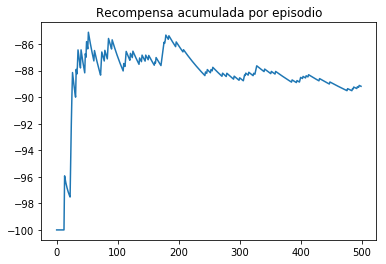

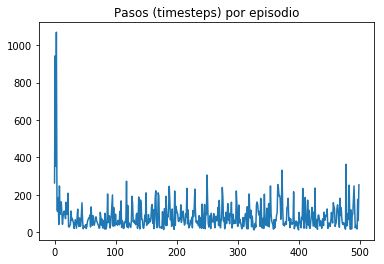

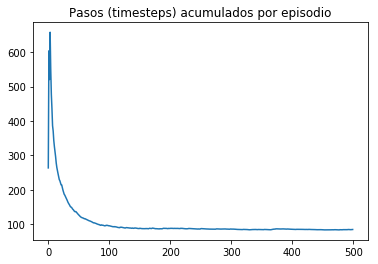

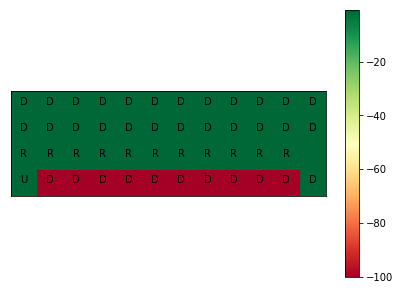


 Matriz de mejor acción-valor (en números): 

 [[  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.11111111
    -1.11111111   -1.1111111    -1.111111     -1.11111      -1.1111
    -1.111        -1.11      ]
 [  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.11111111
    -1.1111111    -1.111111     -1.11111      -1.1111       -1.111
    -1.11         -1.1       ]
 [  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.1111111
    -1.111111     -1.11111      -1.1111       -1.111        -1.11
    -1.1          -1.        ]
 [  -1.11111111 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.5 ALFA=0.1 EPSILON=0.05


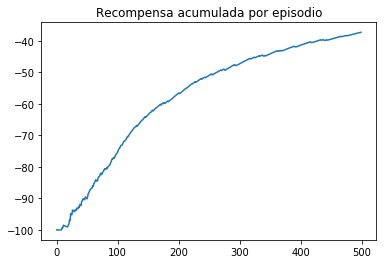

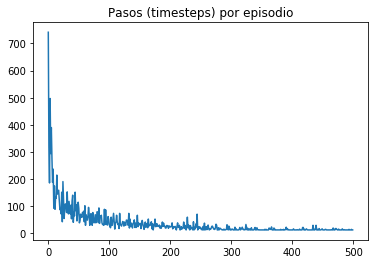

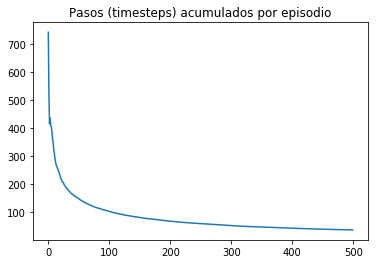

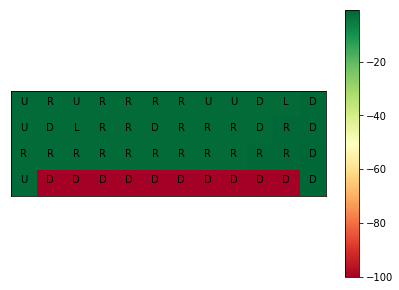


 Matriz de mejor acción-valor (en números): 

 [[  -1.99892624   -1.9985087    -1.99766607   -1.99615972   -1.99352616
    -1.98893816   -1.98092572   -1.9666813    -1.94171858   -1.89974828
    -1.83161806   -1.72512875]
 [  -1.99922267   -1.99875128   -1.99790358   -1.99631345   -1.99340729
    -1.9880789    -1.97849796   -1.9606425    -1.92660627   -1.864348
    -1.74256605   -1.49977571]
 [  -1.99951172   -1.99902344   -1.99804687   -1.99609375   -1.9921875
    -1.984375     -1.96875      -1.9375       -1.875        -1.75
    -1.5          -1.        ]
 [  -1.99975586 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.5 ALFA=0.1 EPSILON=0.1


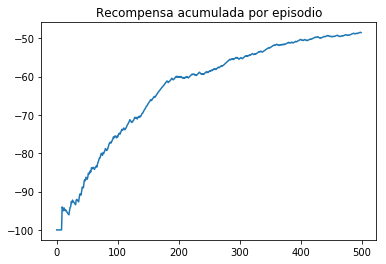

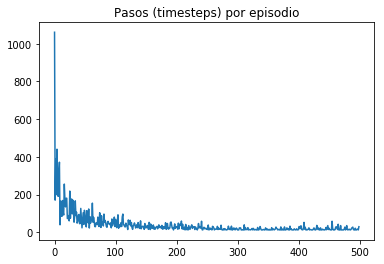

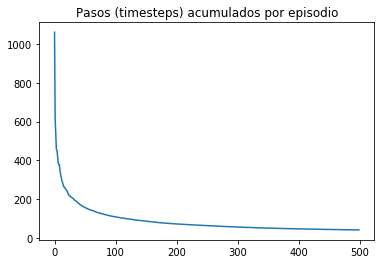

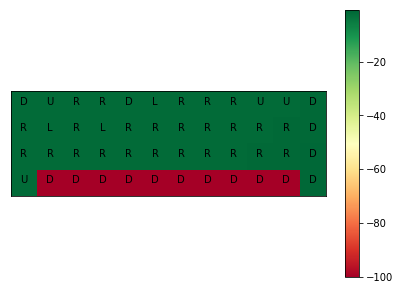


 Matriz de mejor acción-valor (en números): 

 [[  -1.99899407   -1.99860858   -1.99788532   -1.99654798   -1.99419703
    -1.99001724   -1.98283173   -1.96992169   -1.94708756   -1.90743829
    -1.837426     -1.73391517]
 [  -1.99926583   -1.99887407   -1.99812728   -1.99679041   -1.99421139
    -1.98954123   -1.98106564   -1.96452631   -1.93267962   -1.8700977
    -1.74664788   -1.49995348]
 [  -1.99951172   -1.99902344   -1.99804687   -1.99609375   -1.9921875
    -1.984375     -1.96875      -1.9375       -1.875        -1.75
    -1.5          -1.        ]
 [  -1.99975586 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.5 ALFA=0.1 EPSILON=0.5


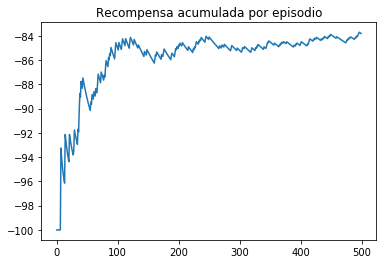

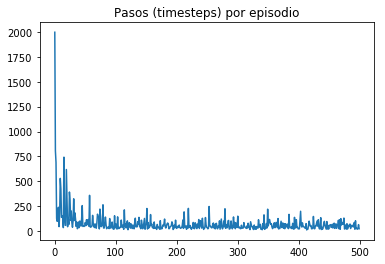

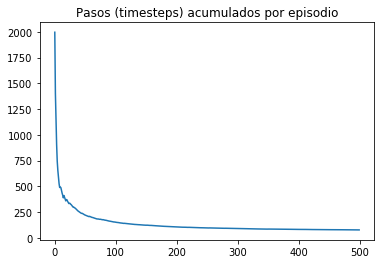

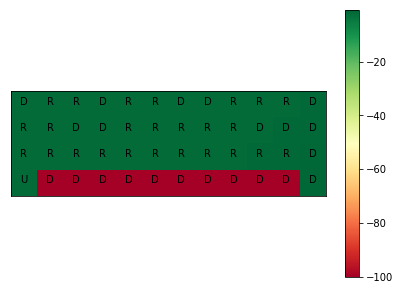


 Matriz de mejor acción-valor (en números): 

 [[  -1.99980033   -1.99971721   -1.99947613   -1.99897897   -1.99799707
    -1.99604337   -1.99211919   -1.9842896    -1.96865937   -1.93740959
    -1.8749208    -1.74999784]
 [  -1.99975578   -1.99951164   -1.99902333   -1.99804674   -1.9960936
    -1.99218731   -1.98437479   -1.96874975   -1.93749983   -1.8749999
    -1.74999997   -1.5       ]
 [  -1.99951172   -1.99902344   -1.99804687   -1.99609375   -1.9921875
    -1.984375     -1.96875      -1.9375       -1.875        -1.75
    -1.5          -1.        ]
 [  -1.99975586 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.5 ALFA=0.5 EPSILON=0.05


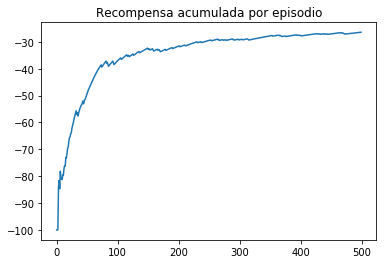

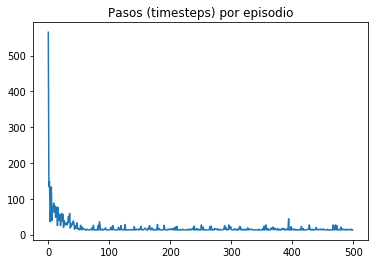

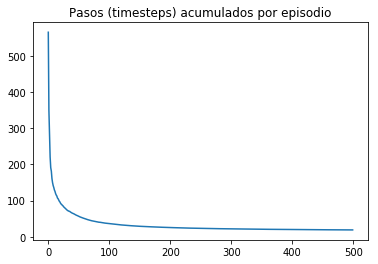

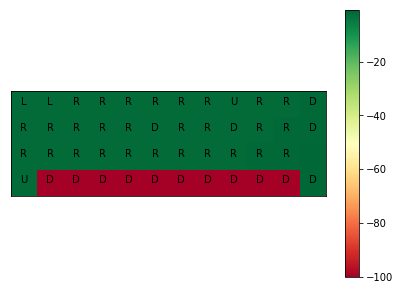


 Matriz de mejor acción-valor (en números): 

 [[  -1.99952378   -1.99933356   -1.99888936   -1.99809572   -1.99664365
    -1.99389251   -1.98870424   -1.97854329   -1.95848259   -1.92493836
    -1.86542464   -1.74743831]
 [  -1.9996697    -1.99940449   -1.99895742   -1.99798057   -1.9960018
    -1.99210932   -1.98428849   -1.96866472   -1.93746691   -1.87497761
    -1.7499891    -1.49999999]
 [  -1.99951172   -1.99902344   -1.99804688   -1.99609375   -1.9921875
    -1.984375     -1.96875      -1.9375       -1.875        -1.75
    -1.5          -1.        ]
 [  -1.99975586 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.5 ALFA=0.5 EPSILON=0.1


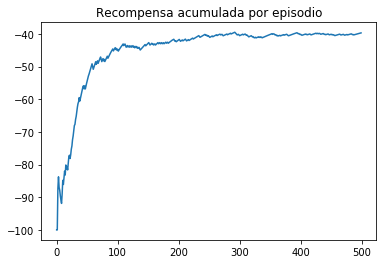

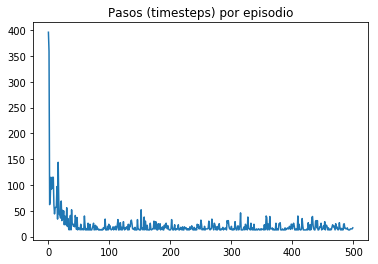

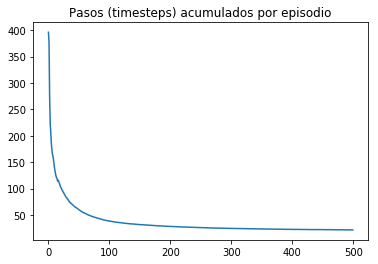

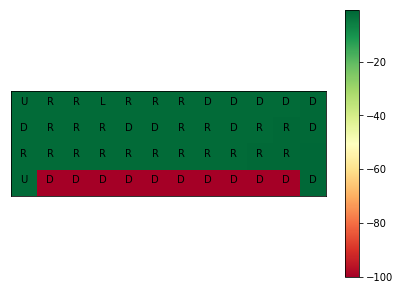


 Matriz de mejor acción-valor (en números): 

 [[  -1.99964284   -1.99944043   -1.99904187   -1.99823546   -1.99688573
    -1.99426563   -1.98954226   -1.98018094   -1.96415745   -1.93236311
    -1.86960739   -1.74948218]
 [  -1.99974035   -1.9995056    -1.99901816   -1.99804342   -1.99609241
    -1.99218653   -1.98437417   -1.96874922   -1.93749942   -1.87499978
    -1.74999998   -1.5       ]
 [  -1.99951172   -1.99902344   -1.99804688   -1.99609375   -1.9921875
    -1.984375     -1.96875      -1.9375       -1.875        -1.75
    -1.5          -1.        ]
 [  -1.99975586 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=0.5 ALFA=0.5 EPSILON=0.5


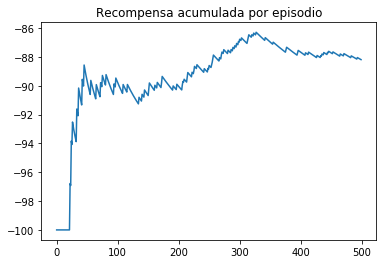

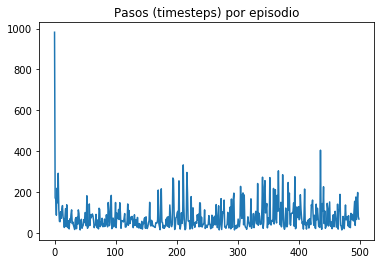

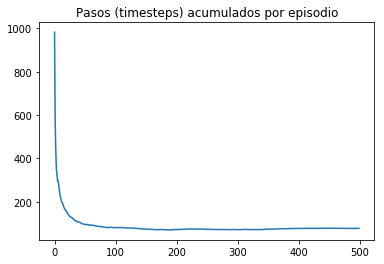

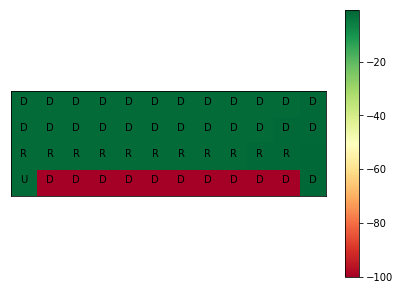


 Matriz de mejor acción-valor (en números): 

 [[  -1.99987793   -1.99975586   -1.99951172   -1.99902344   -1.99804688
    -1.99609375   -1.9921875    -1.984375     -1.96875      -1.9375
    -1.875        -1.75      ]
 [  -1.99975586   -1.99951172   -1.99902344   -1.99804688   -1.99609375
    -1.9921875    -1.984375     -1.96875      -1.9375       -1.875
    -1.75         -1.5       ]
 [  -1.99951172   -1.99902344   -1.99804688   -1.99609375   -1.9921875
    -1.984375     -1.96875      -1.9375       -1.875        -1.75
    -1.5          -1.        ]
 [  -1.99975586 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=1 ALFA=0.1 EPSILON=0.05


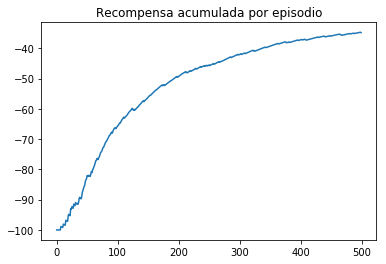

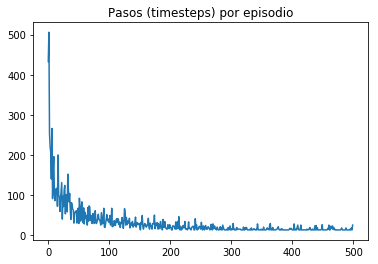

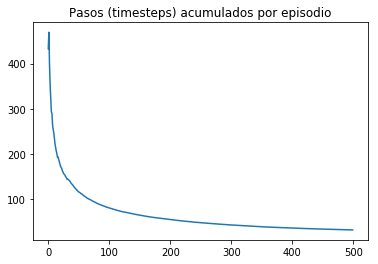

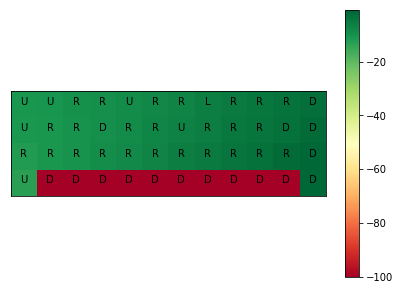


 Matriz de mejor acción-valor (en números): 

 [[ -10.89549297  -10.47990798   -9.8541984    -9.14187529   -8.39441766
    -7.63518208   -6.81439404   -5.99175979   -5.21408943   -4.39242802
    -3.60341483   -2.87364349]
 [ -11.36910194  -10.72076683   -9.97496602   -9.20948334   -8.39605142
    -7.52002716   -6.64332435   -5.75769317   -4.85556644   -3.92189441
    -2.97249471   -1.99935008]
 [ -11.99999999  -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -12.99999996 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=1 ALFA=0.1 EPSILON=0.1


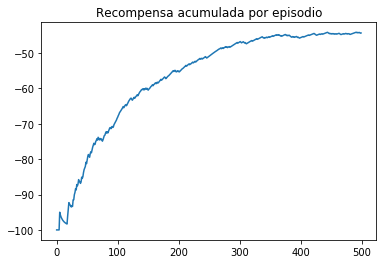

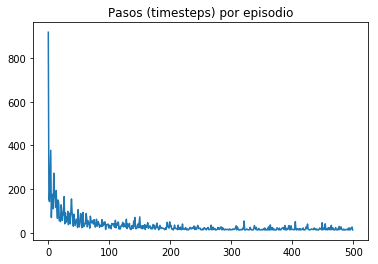

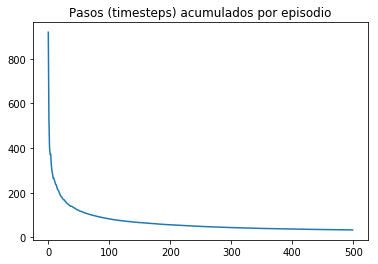

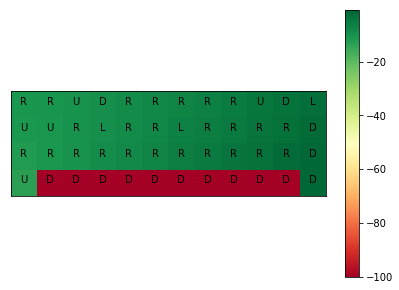


 Matriz de mejor acción-valor (en números): 

 [[ -10.9969936   -10.54344985   -9.92386355   -9.22480615   -8.48239129
    -7.7146995    -6.9169553    -6.11164196   -5.2726135    -4.46565805
    -3.67610018   -2.922825  ]
 [ -11.42914326  -10.8752452   -10.1135861    -9.29663555   -8.51042393
    -7.6557597    -6.78267715   -5.86719166   -4.9254064    -3.96353162
    -2.9893621    -1.9999227 ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=1 ALFA=0.1 EPSILON=0.5


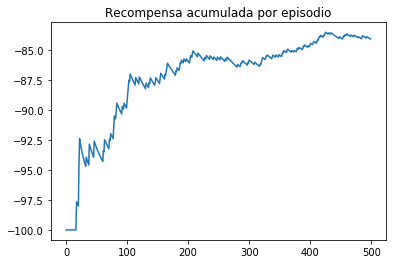

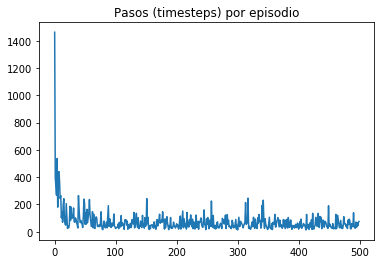

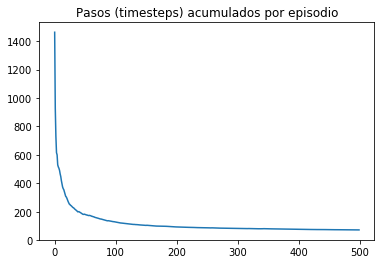

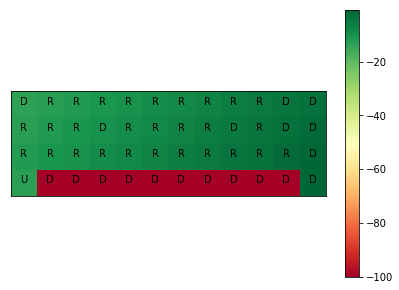


 Matriz de mejor acción-valor (en números): 

 [[ -13.56079994  -12.87871061  -11.95109007  -10.97540912   -9.98574518
    -8.9904621    -7.99440738   -6.99575277   -5.99757394   -4.99900373
    -3.99971015   -2.99999843]
 [ -12.99969026  -11.99984829  -10.99991356   -9.9999448    -8.99996001
    -7.99998064   -6.99999065   -5.99999541   -4.99999841   -3.99999953
    -2.99999989   -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=1 ALFA=0.5 EPSILON=0.05


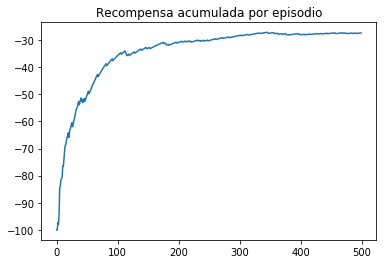

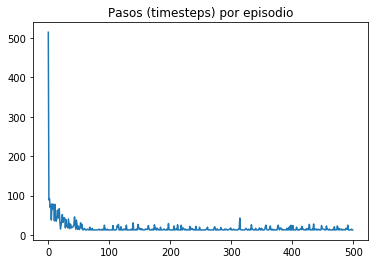

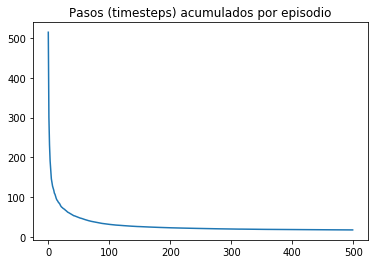

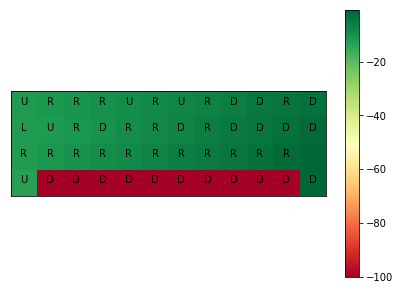


 Matriz de mejor acción-valor (en números): 

 [[ -11.453125    -11.22094651  -10.5572858    -9.85322303   -9.
    -8.13118302   -7.30932617   -6.54536334   -5.72134775   -4.83305057
    -3.92760476   -2.98753616]
 [ -12.          -11.6046033   -10.92823029   -9.96981645   -8.98928744
    -7.99563299   -6.99808247   -5.99906683   -4.99952149   -3.99987195
    -2.99999168   -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=1 ALFA=0.5 EPSILON=0.1


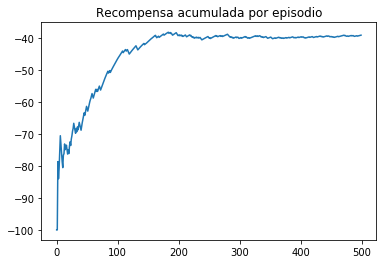

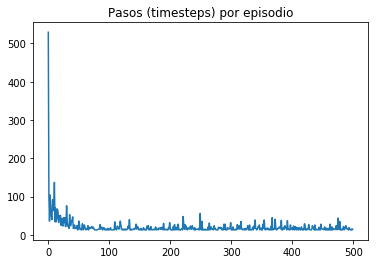

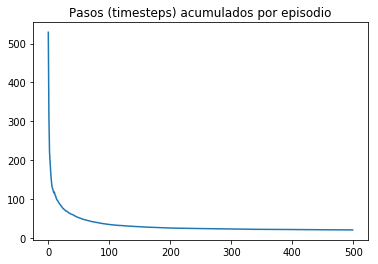

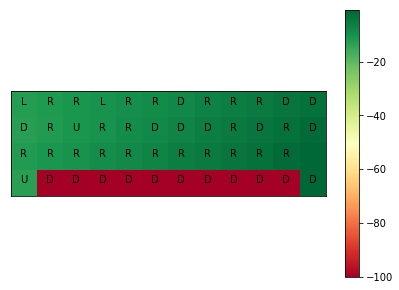


 Matriz de mejor acción-valor (en números): 

 [[ -12.5         -11.65704828  -10.8120446   -10.0360349    -9.23902824
    -8.42749727   -7.60663413   -6.75855739   -5.84045247   -4.92688098
    -3.96396385   -2.99780558]
 [ -12.95605642  -11.9918736   -10.99707762   -9.99913325   -8.99973961
    -7.99992878   -6.99996681   -5.99999418   -4.99999901   -3.99999957
    -2.99999987   -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


VALORES GAMMA=1 ALFA=0.5 EPSILON=0.5


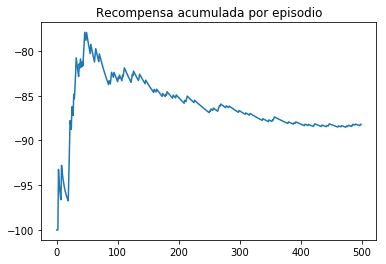

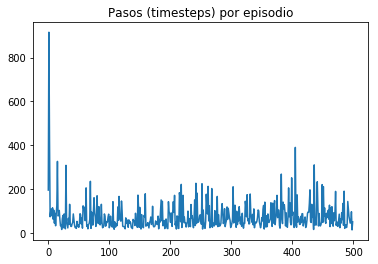

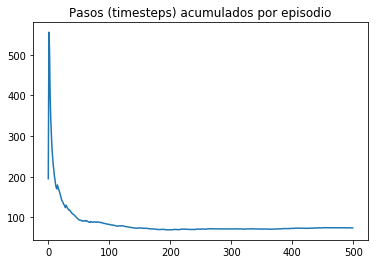

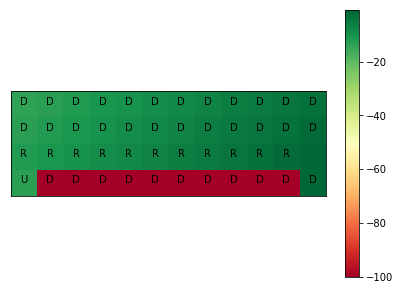


 Matriz de mejor acción-valor (en números): 

 [[ -14.  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.]
 [ -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.]
 [ -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.]
 [ -13. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


In [22]:
lista_gamma = [0.1, 0.5, 1]
lista_alfa = [0.1, 0.5]
lista_epsilon = [0.05, 0.1, 0.5]

for i in lista_gamma:
    for j in lista_alfa:
        for k in lista_epsilon:
            q = {}

            alpha = j
            gamma = i
            epsilon = k
            tau = 25

            episodes_to_run = 500

            env = gym.make("CliffWalking-v0")
            actions = range(env.action_space.n)
            
            print("\n")
            print("VALORES GAMMA={} ALFA={} EPSILON={}".format(gamma, alpha, epsilon))

            avg_steps_per_episode, timesteps_ep, reward_ep = run_qlearning(q, gamma, alpha, epsilon, actions)
            plotting_all(reward_ep, timesteps_ep)
            env.close()


Analizando los resultados anteriores podemos ver que el mejor modelo es el que toma los valores **alfa=0.5, epsilon=0.05** obteniendo la misma performance indistintamente del valor del **gamma**

Comparando con SARSA, **Q-LEARNING** tuvo una mejor performance, ya que presenta mejores tasas de aprendizaje para las configuraciones de hiperparámetros testeadas.